# Traffic Sign Detection

Data folders have been manually cleaned to remove any residual files (.DSStore) that are not images. Manual cleaning was done as part of visual inspection of the data folders and since not many such files were present, it was easier to manually dlete them. The data is now ready to be used for training.

#### Import libraries

In [113]:
# import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

#### Declare lists to build the dataset

In [114]:
path_to_dataset = 'Dataset/trafficsigns_dataset'
image_path = []
sign_shape = []
sign_type = []

#### Recursively fetch the image paths, type and shape from the folders

In [115]:
# Traverse the folder tree and get the image paths, type and shape
for shape_folder in os.listdir(path_to_dataset):
    shape_path = os.path.join(path_to_dataset, shape_folder)
    if os.path.isdir(shape_path):
        # get the parent shape folders
        for type_folder in os.listdir(shape_path):
            sign_path = os.path.join(shape_path, type_folder)
            if os.path.isdir(sign_path):
                # get the type folders
                for image_file in os.listdir(sign_path):
                    # save the image paths, type and shape
                    image_path.append(os.path.join(sign_path, image_file))
                    sign_shape.append(shape_folder)
                    sign_type.append(type_folder)


#### Build the dataframe

In [116]:
# Create a DataFrame from the data
data = {'Path': image_path, 'Shape': sign_shape, 'Type': sign_type}
df = pd.DataFrame(data)
df.head(5)

,Path,Shape,Type
0,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond,rightofway
1,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond,rightofway
2,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond,rightofway
3,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond,rightofway
4,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond,rightofway


#### Data Exploration

In [117]:
# Print the information of the DataFrame
print("##########################")
print("Shape: ", df.shape)
print("##########################")
print("Missing Values:")
print(df.isna().sum())
print("##########################")
print("Data Types:")
print(df.dtypes)
print("##########################")
print("Unique Shapes:")
print(df['Shape'].unique())
print("##########################")
print("Unique Signs:")
print(df['Type'].unique())

##########################
Shape:  (3699, 3)
##########################
Missing Values:
Path     0
Shape    0
Type     0
dtype: int64
##########################
Data Types:
Path     object
Shape    object
Type     object
dtype: object
##########################
Unique Shapes:
['diamond' 'hex' 'square' 'triangle' 'round']
##########################
Unique Signs:
['rightofway' 'stop' 'laneend' 'parking' 'continue' 'crossing' 'giveway'
 'warning' 'traveldirection' 'limitedtraffic' 'speed' 'roundabout'
 'noentry' 'noparking' 'bicycle' 'trafficdirective']


In [118]:
# Count the number of each unique shape in the DataFrame
shape_counts = df['Shape'].value_counts()
print("Shape Counts:")
print(shape_counts)

Shape Counts:
Shape
round       1760
triangle     926
square       688
diamond      282
hex           43
Name: count, dtype: int64


In [119]:
# Count the number of each unique type in the DataFrame
shape_counts = df['Type'].value_counts()
print("Shape Counts:")
print(shape_counts)

Shape Counts:
Type
warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: count, dtype: int64


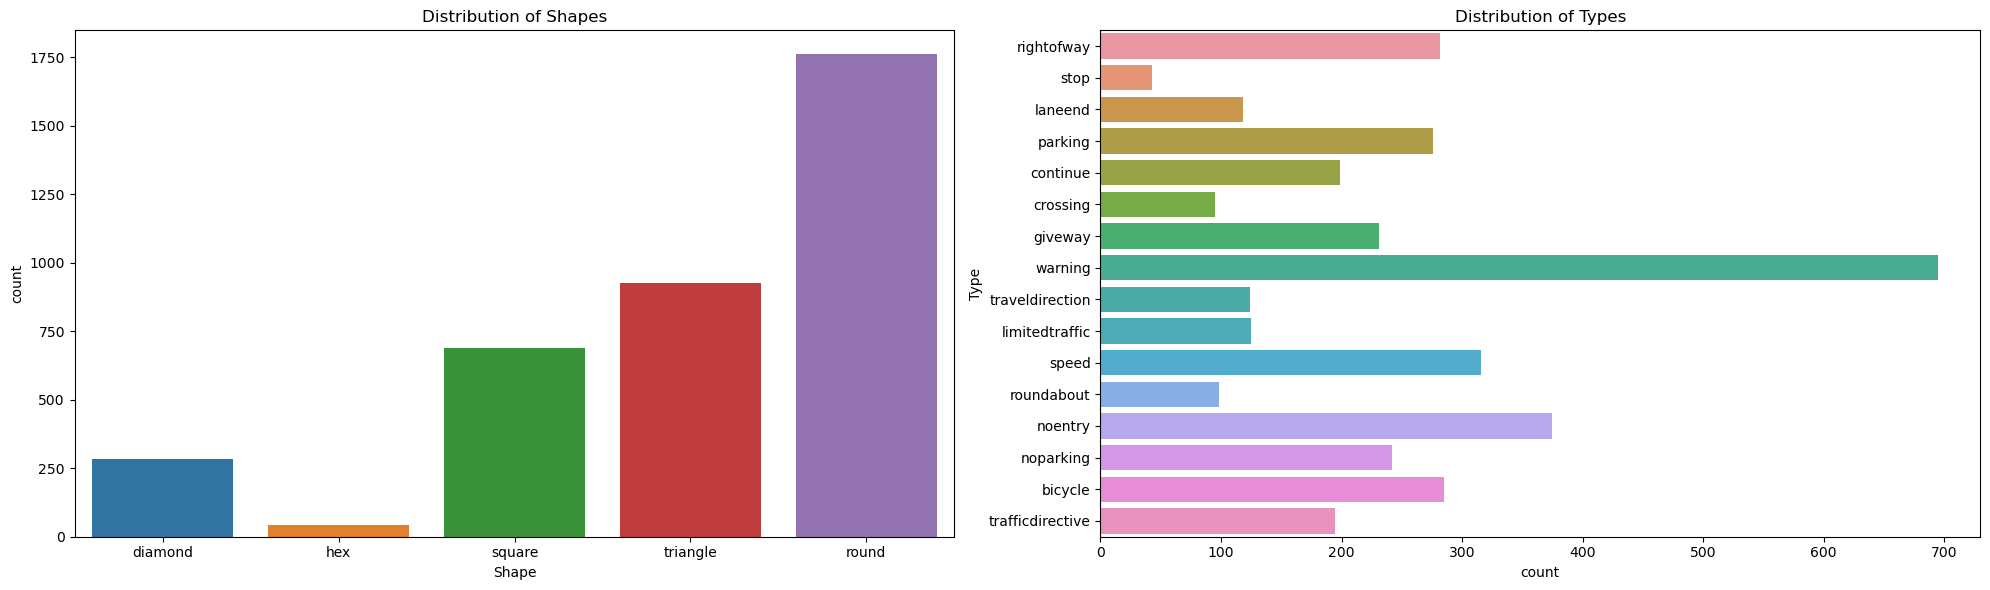

In [120]:
# plot distribution of each class
fig, axs = plt.subplots(1, 2, figsize=(20,6))

# Plot distribution of each class within shape
sns.countplot(data=df, x='Shape', ax=axs[0])
axs[0].set_title('Distribution of Shapes')

# Plot distribution of each class within type
sns.countplot(data=df, y='Type', ax=axs[1])
axs[1].set_title('Distribution of Types')

plt.tight_layout()
plt.show()


##### TODO: There is Class imbalance. Need to handle this (Train test validation split)

#### Check image dimensions

In [121]:
# Iterate through each image path in the DataFrame
for index, row in df.iterrows():
    image_path = row['Path']
    flag = False

    # Open the image using PIL
    with Image.open(image_path) as img:
        width, height = img.size
        # Check if dimensions are not 28x28
        if width != 28 or height != 28:
            flag = True
            print(f"Image at path {image_path} has dimensions {width}x{height}")

if not flag:
    print("All images have dimensions 28x28")
        

All images have dimensions 28x28


### Data Preprocessing

#### Normalise the pixel values between 0 and 1

In [122]:
# Function to normalize pixel values of an image
def normalize_image(image_path):
    # Open the image using PIL
    with Image.open(image_path) as img:
        # Convert image to numpy array
        img_array = np.array(img)
        # Normalize pixel values
        normalized_img = img_array / 255.0
        return normalized_img

# Normalize pixel values for each image and replace the original image data in the DataFrame
df['Normalized_Image'] = df['Path'].apply(normalize_image)

# Display the DataFrame with normalized images
print(df.head())

                                                Path    Shape        Type  \
0  Dataset/trafficsigns_dataset/diamond/rightofwa...  diamond  rightofway   
1  Dataset/trafficsigns_dataset/diamond/rightofwa...  diamond  rightofway   
2  Dataset/trafficsigns_dataset/diamond/rightofwa...  diamond  rightofway   
3  Dataset/trafficsigns_dataset/diamond/rightofwa...  diamond  rightofway   
4  Dataset/trafficsigns_dataset/diamond/rightofwa...  diamond  rightofway   

                                    Normalized_Image  
0  [[0.25882352941176473, 0.2627450980392157, 0.2...  
1  [[0.22745098039215686, 0.23921568627450981, 0....  
2  [[0.39215686274509803, 0.4, 0.3921568627450980...  
3  [[0.4588235294117647, 0.5215686274509804, 0.53...  
4  [[0.24705882352941178, 0.2901960784313726, 0.2...  


In [123]:
# drop the path column
df = df.drop('Path', axis=1)
df.head(2)

,Shape,Type,Normalized_Image
0,diamond,rightofway,"[[0.25882352941176473, 0.2627450980392157, 0.2..."
1,diamond,rightofway,"[[0.22745098039215686, 0.23921568627450981, 0...."


#### Split the dataframe for classification on shape and type

In [124]:
# Split dataframe with "Shape" as target column
df_shape = df.drop('Type', axis=1)

# Split dataframe with "Type" as target column
df_type = df.drop('Shape', axis=1)

In [125]:
df_shape.head(5)

,Shape,Normalized_Image
0,diamond,"[[0.25882352941176473, 0.2627450980392157, 0.2..."
1,diamond,"[[0.22745098039215686, 0.23921568627450981, 0...."
2,diamond,"[[0.39215686274509803, 0.4, 0.3921568627450980..."
3,diamond,"[[0.4588235294117647, 0.5215686274509804, 0.53..."
4,diamond,"[[0.24705882352941178, 0.2901960784313726, 0.2..."


In [126]:
df_type.head(5)

,Type,Normalized_Image
0,rightofway,"[[0.25882352941176473, 0.2627450980392157, 0.2..."
1,rightofway,"[[0.22745098039215686, 0.23921568627450981, 0...."
2,rightofway,"[[0.39215686274509803, 0.4, 0.3921568627450980..."
3,rightofway,"[[0.4588235294117647, 0.5215686274509804, 0.53..."
4,rightofway,"[[0.24705882352941178, 0.2901960784313726, 0.2..."


In [127]:
# label encode the 'Shape' column
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Fit the encoder to the 'Shape' column and transform it
# Round -> 2
# Square -> 3
# Hex -> 1
# Diamond -> 0
# Triangle -> 4
df_shape['Shape'] = le.fit_transform(df_shape['Shape'])

# Do the same for the 'Type' column
# warning -> 15        
# noentry -> 6            
# speed   -> 11            
# bicycle -> 0            
# rightofway -> 9         
# parking    -> 8         
# noparking  -> 7         
# giveway    -> 3         
# continue   -> 1         
# trafficdirective -> 13   
# limitedtraffic   -> 5   
# traveldirection  -> 14   
# laneend          -> 4   
# roundabout       -> 10   
# crossing         -> 2   
# stop             -> 12   
df_type['Type'] = le.fit_transform(df_type['Type'])
df_type['Type'].value_counts()

Type
15    695
6     375
11    316
0     285
9     282
8     276
7     242
3     231
1     199
13    195
5     125
14    124
4     118
10     98
2      95
12     43
Name: count, dtype: int64

#### One Hot Encode the classes

In [128]:
# # One-hot encode the 'Shape' column
# shape_encoded = pd.get_dummies(df_shape['Shape'], prefix='Shape')

# # One-hot encode the 'Sign' column
# sign_encoded = pd.get_dummies(df_type['Type'], prefix='Type')

# # Concatenate the encoded columns with the original DataFrame
# df_shape_encoded = pd.concat([df_shape, shape_encoded], axis=1)

# # Concatenate the encoded columns with the original DataFrame
# df_type_encoded = pd.concat([df_type, sign_encoded], axis=1)

# # Drop the original 'Shape' and 'Sign' columns
# df_shape_encoded.drop(['Shape'], axis=1, inplace=True)
# df_type_encoded.drop(['Type'], axis=1, inplace=True)

In [129]:
print('################################# Encoded Shape dataframe #################################\n')
print(df_shape.head(5), '\n')
print('################################# Encoded Type dataframe #################################\n')
print(df_type.head(5), '\n')

################################# Encoded Shape dataframe #################################

   Shape                                   Normalized_Image
0      0  [[0.25882352941176473, 0.2627450980392157, 0.2...
1      0  [[0.22745098039215686, 0.23921568627450981, 0....
2      0  [[0.39215686274509803, 0.4, 0.3921568627450980...
3      0  [[0.4588235294117647, 0.5215686274509804, 0.53...
4      0  [[0.24705882352941178, 0.2901960784313726, 0.2... 

################################# Encoded Type dataframe #################################

   Type                                   Normalized_Image
0     9  [[0.25882352941176473, 0.2627450980392157, 0.2...
1     9  [[0.22745098039215686, 0.23921568627450981, 0....
2     9  [[0.39215686274509803, 0.4, 0.3921568627450980...
3     9  [[0.4588235294117647, 0.5215686274509804, 0.53...
4     9  [[0.24705882352941178, 0.2901960784313726, 0.2... 



In [130]:
# # Convert the boolean encoding to integer
# def bool_to_int(df_encoded) -> pd.DataFrame:
#     """Convert boolean encoding to integer encoding"""
#     for col in df_encoded.columns:
#         if df_encoded[col].dtype == bool:
#             df_encoded[col] = df_encoded[col].astype(int)
#     return df_encoded

In [131]:
# # Convert boolean encoding to integer encoding
# df_shape_encoded = bool_to_int(df_shape_encoded)
# df_type_encoded = bool_to_int(df_type_encoded)

In [132]:
# # Display the DataFrame
# print('################################# Encoded Shape dataframe #################################\n')
# print(df_shape_encoded.head(5), '\n')
# print('################################# Encoded Type dataframe #################################\n')
# print(df_type_encoded.head(5), '\n')

In [137]:
# print the shape of the encoded dataframes to ensure they have the same number of rows after preprocessing
print(df_shape.shape)
print(df_type.shape)

(3699, 2)
(3699, 2)


In [134]:
# save the preprocessed dataframes to csv files
df_shape.to_csv('Dataset/trafficsigns_dataset/shape_preprocessed.csv', index=False)
df_type.to_csv('Dataset/trafficsigns_dataset/type_preprocessed.csv', index=False)